# 5.5 Estimating the Test Error

In the previous lesson, we learned about _training error_, which is the error calculated on the training data. Training error is easy to calculate because the true labels are available in the training data. However, training error is not always a good measure of a model's quality, since a model that _overfits_ to the training data may have artificially low training error.

Ideally, we would like to evaluate regression models based on their _test error_, which is the error calculated on the test data. The problem with test error is that it is usually impossible to calculate, since the true labels are rarely available in the test data. In this section, we discuss strategies for estimating the test error using only the training data.

In [1]:
import pandas as pd
import numpy as np

# Extract the training data.
data_dir = "https://dlsun.github.io/pods/data/"
bordeaux_df = pd.read_csv(data_dir + "bordeaux.csv",
                          index_col="year")
bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])

## Validation Error

To estimate the test error, we split the training data into a _training set_ and a _validation set_. First, the model is fit to just the data in the training set. Then, the model is evaluated based on its predictions on the validation set. Because the model did not train on any of the labels in the validation set, the validation set essentially plays the role of the test data, even though it was carved out of the training data.

The prediction error on the validation set is known as the _validation error_. The validation error is an approximation to the test error.

To split our data into training and validation sets, we can use the `.sample()` function in `pandas`. Let's use this to split our data into two equal halves, which we will call `train` and `val`.

In [2]:
train = bordeaux_train.sample(frac=.5)
val = bordeaux_train.drop(train.index)

train

,price,summer,har,sep,win,age,log(price)
year,,,,,,,
1970,40.0,16.7,89,18.0,622,22,3.688879
1955,45.0,17.1,130,16.8,502,37,3.806662
1961,100.0,17.3,38,20.4,830,31,4.605170
1976,25.0,17.6,247,16.1,418,16,3.218876
1968,11.0,16.2,292,16.4,610,24,2.397895
1977,11.0,15.6,87,16.8,821,15,2.397895
1952,37.0,17.1,160,14.3,600,40,3.610918
1972,10.0,15.0,158,14.6,536,20,2.302585
1953,63.0,16.7,80,17.3,690,39,4.143135


Now let's use these training/validation sets to approximate the test MSE of the 5-nearest neighbors model that we fit in Chapter 5.2.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

# extract features and label from training set
X_train = train[["win", "summer"]]
y_train = train["log(price)"]

# define pipeline and fit to training set
pipeline = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=5)
)
pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

We make predictions on the validation set and calculate the validation RMSE:

In [4]:
from sklearn.metrics import mean_squared_error

# extract features and label from validation set
X_val = val[["win", "summer"]]
y_val = val["log(price)"]

# get model's predictions on validation set
y_val_ = pipeline.predict(X_val)

# calculate RMSE on validation set
rmse = np.sqrt(mean_squared_error(y_val, y_val_))
rmse

0.44169569869735253

Notice that the test error is higher than the training error that we calculated in the previous lesson. In general, this will be true. It is harder for a model to predict for new observations it has not seen, than for observations it has seen!

## Cross Validation

The validation error above was calculated using only 50% of the training data, since we split the training data in half to create the validation set. As a result, the estimate is noisy.

There is a cheap way to obtain a second opinion about how well our model will do on future data. Previously, we split our data at random into two halves, fitting the model to the first half and evaluating it on the second half. Because the model has not already seen the second half of the data, this approximates how well the model would perform on future data. 

But the way we split our data was arbitrary. We might as well swap the roles of the two halves, fitting the model to the _second_ half and evaluating it on the _first_ half. As long as the model is always evaluated on data that is different from the data that was used to train it, we have a valid estimate of test error. A schematic of this approach, known as _cross-validation_, is shown below.

![](https://github.com/dlsun/pods/blob/master/05-Regression-Models/cross-validation.png?raw=1)

Because we will be doing all computations twice, just with different data, let's wrap the $k$-nearest neighbors algorithm above into a function called `get_val_error()`, that computes the validation error given training and validation data.

In [5]:
def get_val_error(train, val):
    
    # extract features and label from training set.
    X_train = train[["win", "summer"]]
    y_train = train["log(price)"]
    
    # eefine pipeline and fit to training set
    pipeline = make_pipeline(
          StandardScaler(),
          KNeighborsRegressor(n_neighbors=5)
    )
    pipeline.fit(X=X_train, y=y_train)
    
    # extract features and label from validation set
    X_val = val[["win", "summer"]]
    y_val = val["log(price)"]
    
    # get model's predictions on validation set
    y_val_ = pipeline.predict(X_val)

    # calculate RMSE on validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_val_))
    
    return rmse

If we apply this function to the training and validation sets from earlier, we get the same estimate of the test error.

In [6]:
get_val_error(train, val)

0.44169569869735253

But if we reverse the roles of the training and validation sets, we get another estimate of the test error.

In [7]:
get_val_error(val, train)

0.6103419219176969

Now we have two, somewhat independent estimates of the test error. It is common to average the two numbers to obtain an overall estimate of the test error, called the _cross-validation estimate of test error_. Notice that the cross-validation estimate uses each observation in the data exactly once. We make a prediction for each observation, but always using a model that was trained on data that does not include that observation.

## Cross-Validation in scikit-learn

As you know by now, scikit-learn provides functions that automate routine tasks of machine learning. For cross-validation, there is a function, `cross_val_score`, that takes in a model (or pipeline), the training data, and a scoring function, and carries out all aspects of cross-validation, including

1. splitting the training data into training and validation sets
2. fitting the model to each training set
3. calculating the model's predictions on the corresponding validation set
4. calculating the score of the predictions on each validation set.

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, 
                         X=bordeaux_train[["win", "summer"]],
                         y=bordeaux_train["log(price)"],
                         scoring="neg_mean_squared_error",
                         cv=2)
scores

array([-0.47767636, -0.38655855])

First, notice that there are 2 scores. This is because scikit-learn calculated a score from each half of the data when that half served as the validation set.

Second, observe that the scores are negative. This is because scikit-learn requires that a "score" be something that ought to be maximized. Since we want to minimize the mean-squared error, we want to maximize the *negative* mean-squared error. Therefore, the scores that are reported here are the negative of the MSE.

To calculate the RMSE, we negate the negative sign and take a square root.

In [9]:
np.sqrt(-scores)

array([0.69114134, 0.62173833])

The average of these two scores is the cross-validation estimate of test error.

In [10]:
np.sqrt(-scores).mean()

0.6564398373317621

## $K$-Fold Cross Validation

One problem with splitting the training data into two halves is that the model is now trained on only half the amount of data. This model will likely perform worse than the actual model, which is trained on all of the training data. So the cross-validation estimate of test error is unnecessarily pessimistic.

We would like the size of the training set to be closer to the size of the original training data. We can do this by splitting the data into more than two subsamples. In general, we can split the data into $k$ subsamples, alternately training the data on $k-1$ subsamples and evaluating the model on the $1$ remaining subsample, i.e., the validation set. This produces $k$ somewhat independent estimates of the test error. This procedure is known as **$k$-fold cross validation**. (Be careful not to confuse this $k$ with the $k$ in $k$-nearest neighbors.) In hindsight, the  cross validation that we were doing previously is $2$-fold cross validation.

A schematic of $4$-fold cross validation is shown below.

![](https://github.com/dlsun/pods/blob/master/05-Regression-Models/k-folds.png?raw=1)

Implementing $k$-fold cross validation in scikit-learn is easy. We simply set the `cv=` parameter to the desired number of folds. For example, the following code carries out $4$-fold cross validation.

In [11]:
scores = cross_val_score(pipeline, 
                         X=bordeaux_train[["win", "summer"]],
                         y=bordeaux_train["log(price)"],
                         scoring="neg_mean_squared_error",
                         cv=4)
scores

array([-0.47213584, -0.30601689, -0.36874833, -0.11290777])

Notice that $k$ scores are produced, one from each fold. These scores can be averaged to produce a single estimate of the test error.

In [12]:
np.sqrt(-scores).mean()

0.545893343925109

# Exercises

1\. Use cross-validation to approximate the *test* $R^2$ of the $10$-nearest neighbors regression model that we fit in the lesson of Chapter 5.3 to the Ames housing data set (http://dlsun.github.io/pods/data/AmesHousing.txt ).

In [13]:
ames = pd.read_table("http://dlsun.github.io/pods/data/AmesHousing.txt")
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [16]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct = make_column_transformer(
    (StandardScaler(), ["Gr Liv Area", "Bedroom AbvGr", "Full Bath"]),
    (OneHotEncoder(handle_unknown="ignore"), ["Neighborhood", "Bldg Type"]),
    remainder="drop"
)

from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=10)
)

X_train = ames[["Gr Liv Area", "Bedroom AbvGr", "Full Bath", "Neighborhood", "Bldg Type"]]
y_train = ames["SalePrice"]

scores = cross_val_score(pipeline,
                         X=X_train,
                         y=y_train,
                         scoring="r2",
                         cv=10)
scores.mean()

0.7383048240888024

2\. Using the Tips data set (http://dlsun.github.io/pods/data/tips.csv ), train a $k$-nearest neighbors regression model to predict the tip, for several different values of $k$. Estimate the test MAE of each model and make a graph showing this test error as a function of $k$. How does it compare to the graph of the training MAE?

In [17]:
tips = pd.read_csv("http://dlsun.github.io/pods/data/tips.csv")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [18]:
ct = make_column_transformer(
    (OneHotEncoder(), ["sex", "day"]),
    (StandardScaler(), ["total_bill", "size"]),
    remainder="drop"
)

X_train = tips[["total_bill", "size", "sex", "day"]]
y_train = tips["tip"]

In [22]:
from sklearn.metrics import mean_absolute_error

maes = {}
for k in range(1, 20):
  pipeline = make_pipeline(
      ct,
      KNeighborsRegressor(n_neighbors=k)
  )

  scores = cross_val_score(pipeline,
                           X=X_train,
                           y=y_train,
                           scoring="neg_mean_absolute_error",
                           cv=10)
  
  maes[k] = -scores.mean()

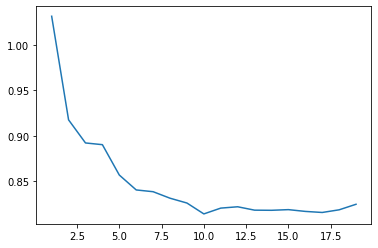

In [23]:
pd.Series(maes).plot.line()